### Setup environment

In [267]:
%pip install numpy pandas matplotlib seaborn scikit-learn mixed-naive-bayes

Note: you may need to restart the kernel to use updated packages.


In [268]:
!wget -nc https://archive.ics.uci.edu/ml/machine-learning-databases/credit-screening/crx.data -O crx.data.csv

File ‘crx.data.csv’ already there; not retrieving.


### 1. Zidentyfikuj w zbiorze Credit approval dataset cechy (tj. kolumny), dla których
brakuje podanych wartości. Uzupełnij brakujące wartości. Do wyboru jest wiele
możliwości, przykładowe z nich to:
- usunięcie kolumn (cech) lub wierszy (przykładów), w których występują
brakujące dane
- uzupełnienie brakujących danych średnią, medianą lub modą wartości
cechy
- uzupełnienie brakujących danych najczęstszą wartością cech, wartością
losową lub wartością zerową
- uzupełnienie brakujących danych metodą nabliższych sąsiadów

Zastanów się, jaki sposób imputacji brakujących danych będzie najbardziej
odpowiedni. Jak będzie wyglądało uzupełnianie brakujących wartości dla
danych numerycznych, a jak dla danych nominalnych?

In [269]:
import numpy as np
import pandas as pd

# Read the data
data = pd.read_csv("crx.data.csv", header=None)

print(data.head())

print(data.dtypes)

  0      1      2  3  4  5  6     7  8  9   10 11 12     13   14 15
0  b  30.83  0.000  u  g  w  v  1.25  t  t   1  f  g  00202    0  +
1  a  58.67  4.460  u  g  q  h  3.04  t  t   6  f  g  00043  560  +
2  a  24.50  0.500  u  g  q  h  1.50  t  f   0  f  g  00280  824  +
3  b  27.83  1.540  u  g  w  v  3.75  t  t   5  t  g  00100    3  +
4  b  20.17  5.625  u  g  w  v  1.71  t  f   0  f  s  00120    0  +
0      object
1      object
2     float64
3      object
4      object
5      object
6      object
7     float64
8      object
9      object
10      int64
11     object
12     object
13     object
14      int64
15     object
dtype: object


In [270]:
cat_cols = [0, 3, 4, 5, 6, 8, 9, 11, 12, 15]
num_cols = [1, 2, 7, 10, 13, 14]

# show all categorical variables
for i in cat_cols:
    print(data[i].unique())

['b' 'a' '?']
['u' 'y' '?' 'l']
['g' 'p' '?' 'gg']
['w' 'q' 'm' 'r' 'cc' 'k' 'c' 'd' 'x' 'i' 'e' 'aa' 'ff' 'j' '?']
['v' 'h' 'bb' 'ff' 'j' 'z' '?' 'o' 'dd' 'n']
['t' 'f']
['t' 'f']
['f' 't']
['g' 's' 'p']
['+' '-']


In [271]:
# replace ? with NaN
data = data.replace('?', np.nan)

# make 1st and 13th column as int (continous), but leave NaN as NaN
data[1] = pd.to_numeric(data[1], errors='coerce')
data[13] = pd.to_numeric(data[13], downcast='integer', errors='coerce')

print(data.isnull().sum())

0     12
1     12
2      0
3      6
4      6
5      9
6      9
7      0
8      0
9      0
10     0
11     0
12     0
13    13
14     0
15     0
dtype: int64


Decydujemy się na usunięcie kolumn, w których występują brakujące dane nominalne.
Uzupełniamy brakujące dane numeryczne medianą.

In [272]:
# delete the rows with missing values in columns 0, 3, 4, 5, 6
data = data.dropna(subset=cat_cols)

# fill the missing values in numerical columns with the median
data[num_cols] = data[num_cols].fillna(data[num_cols].median())

data.isnull().sum()

0     0
1     0
2     0
3     0
4     0
5     0
6     0
7     0
8     0
9     0
10    0
11    0
12    0
13    0
14    0
15    0
dtype: int64

### 2. Zwizualizuj rozkład wartości każdej cechy oraz zależności od innych cechw tzw.
macierzy rozrzutu (ang. scatter matrix).

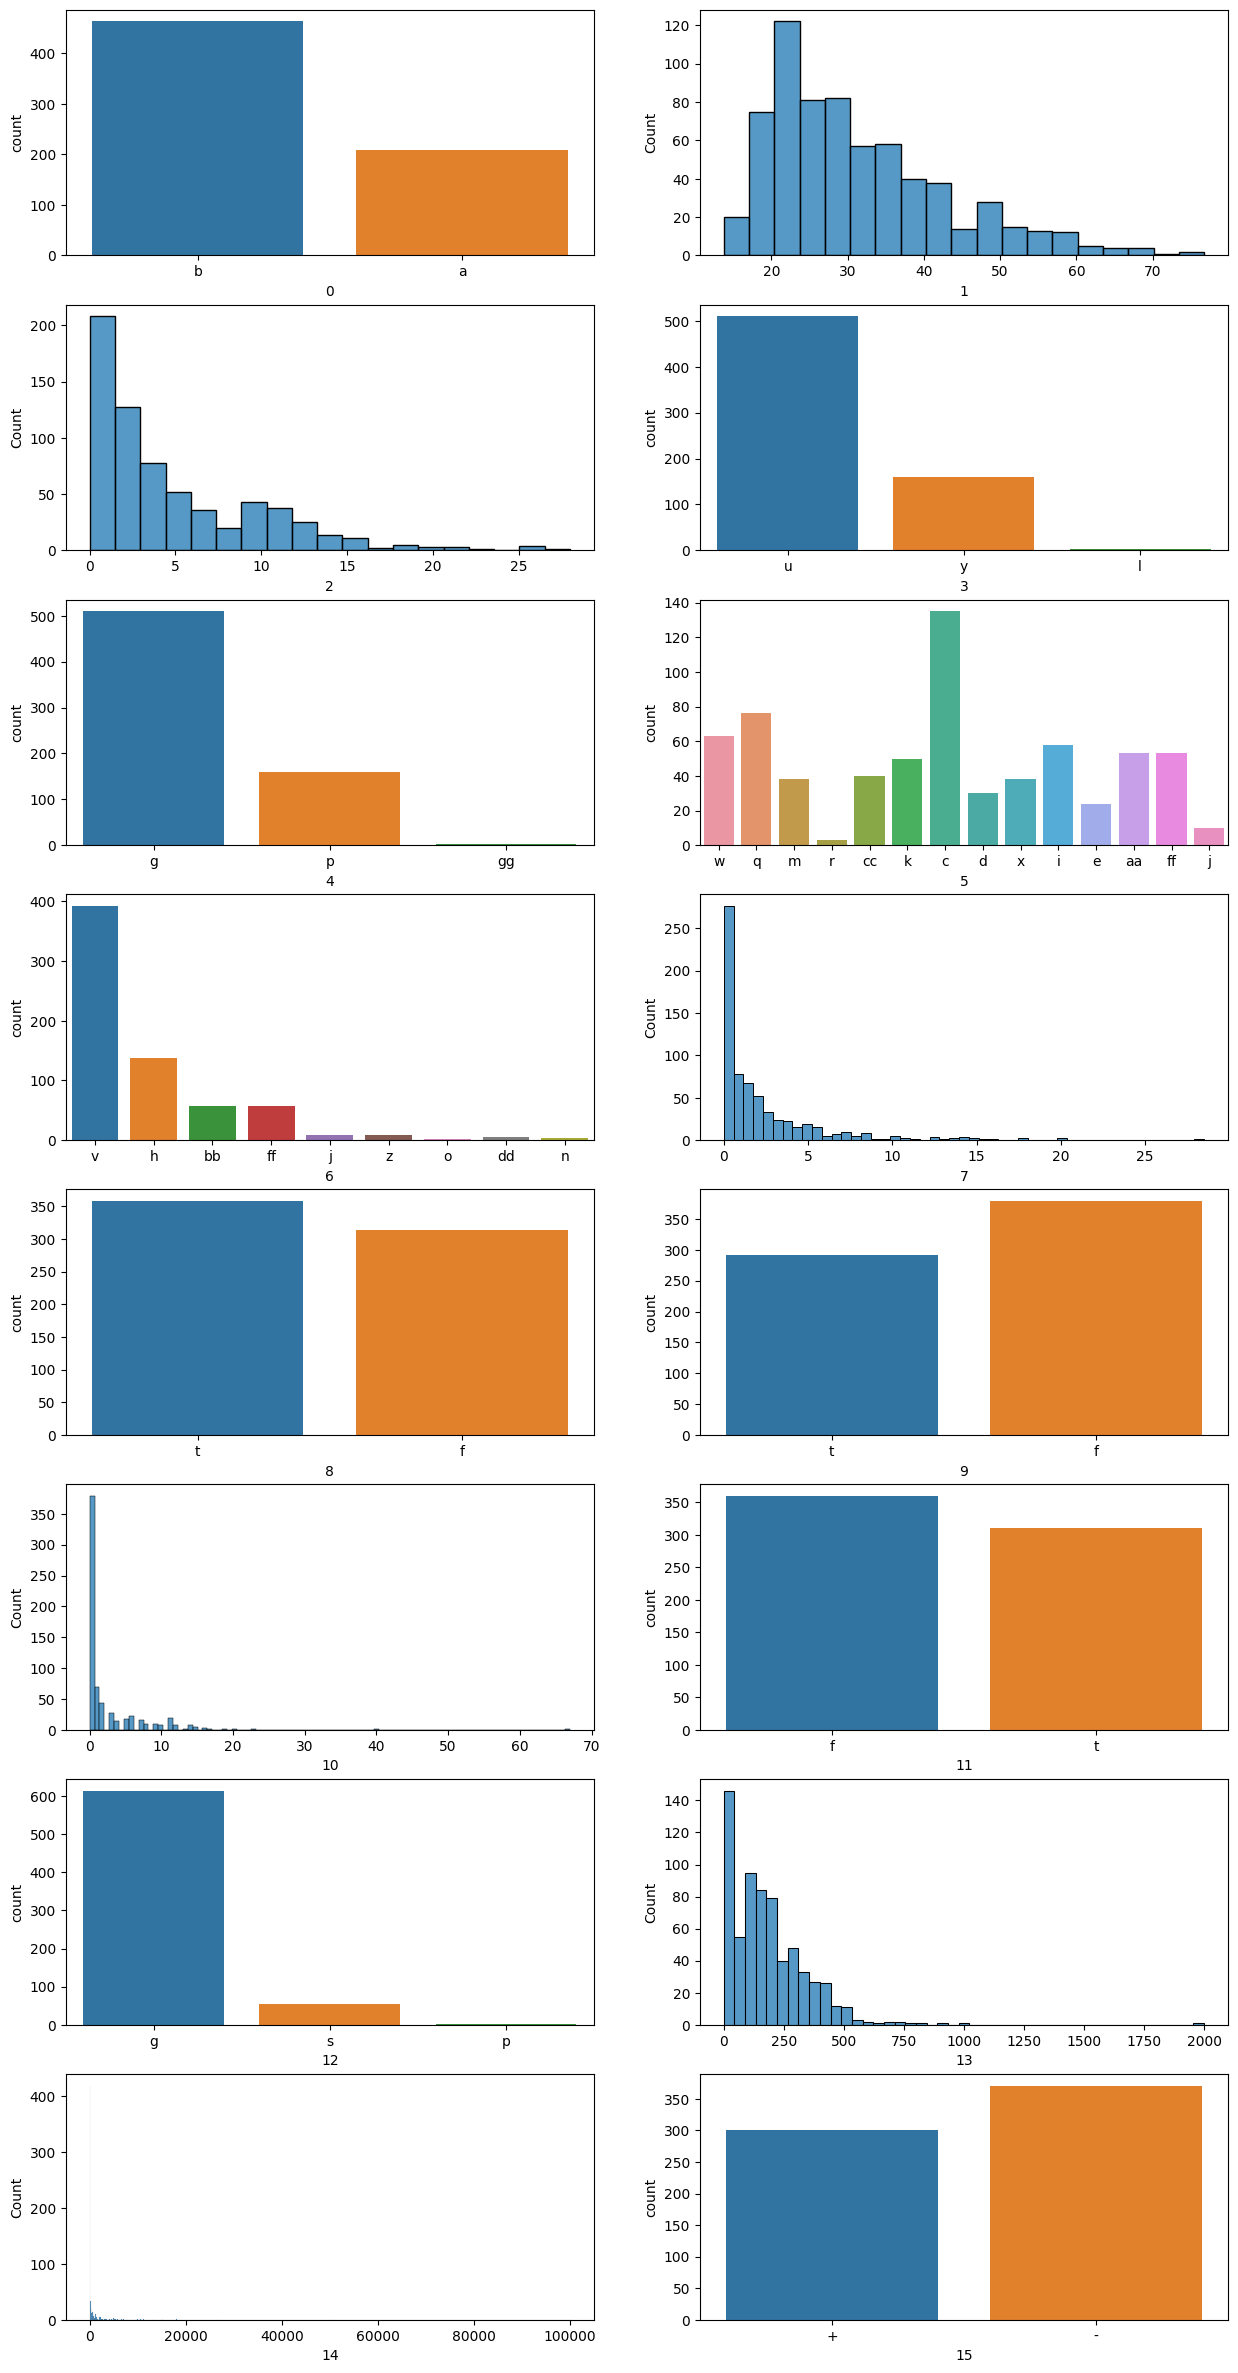

In [273]:
import matplotlib.pyplot as plt
import seaborn as sns

# plot data distribution; categorical variables as bar plots, continuous as bins
fig, axs = plt.subplots(8, 2, figsize=(15, 30))
for i in range(0, 16):
    if i in cat_cols:
        sns.countplot(x=i, data=data, ax=axs[i // 2, i % 2])
    else:
        sns.histplot(x=i, data=data, ax=axs[i // 2, i % 2])


<Axes: >

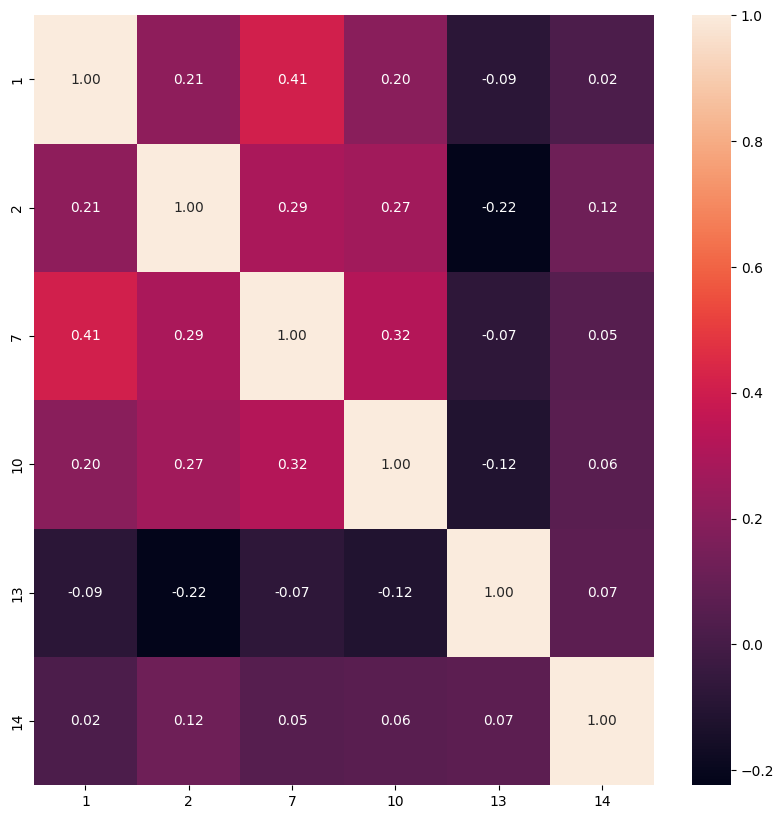

In [274]:
# show the correlation matrix; select only numerical features
data_corr = data.drop(cat_cols, axis=1).corr()
plt.figure(figsize=(10, 10))
sns.heatmap(data_corr, annot=True, fmt=".2f")

### 3. Kodowanie wartości nominalnych. Przeanalizuj, jak klasyfikatory radzą sobie z
reprezentacją cech w postaci nominalnej oraz w kodowaniu one hot encoding.
Które reprezentacje cech są dopuszczalne dla każdego z klasyfikatorów? Jeśli
obie reprezentacje są dopuszczalne, która reprezentacja będzie bardziej
efektywna?

Najpierw testujemy klasyfikatory na danych bez enkodowania.

In [275]:
# check how classifiers handle not-encoded data and encoded data
# we will use: Naive Bayes, k-NN, SVM and Random Forest with default parameters

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# split the data into train and test
X_train, X_test, y_train, y_test = train_test_split(data.drop(15, axis=1), data[15], test_size=0.2, random_state=42)

from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import CategoricalNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier

# check the accuracy of the classifiers
def check_accuracy(clf, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    return accuracy_score(y_test, y_pred)

# catch errors
try:
    print("Naive Bayes accuracy: ", check_accuracy(GaussianNB()))
except Exception as e:
    print("Naive Bayes error: ", e)

try:
    print("k-NN accuracy: ", check_accuracy(KNeighborsClassifier()))
except Exception as e:
    print("k-NN error: ", e)

try:
    print("SVM accuracy: ", check_accuracy(SVC()))
except Exception as e:
    print("SVM error: ", e)

try:
    print("Random Forest accuracy: ", check_accuracy(RandomForestClassifier()))
except Exception as e:
    print("Random Forest error: ", e)

Naive Bayes error:  could not convert string to float: 'a'
k-NN error:  could not convert string to float: 'a'
SVM error:  could not convert string to float: 'a'
Random Forest error:  could not convert string to float: 'a'


Teraz sprawdźmy po one-hot encodingu.

In [276]:
# encode the categorical variables
from sklearn.preprocessing import OneHotEncoder

enc = OneHotEncoder(handle_unknown='ignore')
X_cat_cols = cat_cols.copy()
X_cat_cols.remove(15)

X_train_enc = enc.fit_transform(X_train[X_cat_cols])
X_test_enc = enc.transform(X_test[X_cat_cols])

# convert to dense matrix
X_train_enc = X_train_enc.toarray()
X_test_enc = X_test_enc.toarray()

# check the accuracy of the classifiers
print("Naive Bayes accuracy: ", check_accuracy(GaussianNB(), X_train_enc, X_test_enc))
print("k-NN accuracy: ", check_accuracy(KNeighborsClassifier(), X_train_enc, X_test_enc))
print("SVM accuracy: ", check_accuracy(SVC(), X_train_enc, X_test_enc))
print("Random Forest accuracy: ", check_accuracy(RandomForestClassifier(), X_train_enc, X_test_enc))


Naive Bayes accuracy:  0.762962962962963
k-NN accuracy:  0.8518518518518519
SVM accuracy:  0.8444444444444444
Random Forest accuracy:  0.8666666666666667


Oczywiście, to że powyższe wywołania zwracają błedy nie oznacza że one-hot encoding nie jest dopuszczalny. Wymagany jest odpowiedni klasyfikator wybrany z bilbioteki, który wspierałby wartości nominalne. Istnieje implementacja dla Naive Bayes'a, który obsłuży jednakowo wartości numeryczne jak i nominalne.

In [277]:
from mixed_naive_bayes import MixedNB
from sklearn.preprocessing import LabelEncoder

# encode the categorical variables
le = LabelEncoder()
X_train_mnb = X_train.copy()
X_test_mnb = X_test.copy()
y_train_mnb = y_train.copy()
y_test_mnb = y_test.copy()

X_train_mnb[X_cat_cols] = X_train_mnb[X_cat_cols].apply(le.fit_transform)
X_test_mnb[X_cat_cols] = X_test_mnb[X_cat_cols].apply(le.fit_transform)
y_train_mnb = le.fit_transform(y_train_mnb)
y_test_mnb = le.fit_transform(y_test_mnb)

print("Mixed Naive Bayes accuracy: ", check_accuracy(MixedNB(categorical_features=X_cat_cols), X_train_mnb, X_test_mnb, y_train_mnb, y_test_mnb))

Mixed Naive Bayes accuracy:  0.7407407407407407


Klasyfikator utrzymuje podobny poziom dokładności jak w przypadku zastosowania enkodowania.

### 4. Przeprowadź skalowanie cech. Najczęściej stosuje się jedno z dwóch podejść:
- normalizacja (ang. min-max scaling)
- standaryzacja (ang. standarization)

Zbadaj, jak skalowanie cech wpływa na dokładność klasyfikatorów k-NN oraz
lasów losowych.

In [278]:
# scale numerical values using min-max scaling
from sklearn.preprocessing import MinMaxScaler

MMS = MinMaxScaler()
X_train_scaled = X_train_enc.copy()
X_test_scaled = X_test_enc.copy()

X_train_scaled[num_cols] = MMS.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = MMS.fit_transform(X_test_scaled[num_cols])

# check the accuracy of the classifiers
print("k-NN accuracy: ", check_accuracy(KNeighborsClassifier(), X_train_scaled, X_test_scaled))
print("Random Forest accuracy: ", check_accuracy(RandomForestClassifier(), X_train_scaled, X_test_scaled))

k-NN accuracy:  0.8518518518518519
Random Forest accuracy:  0.8444444444444444


In [279]:
from sklearn.discriminant_analysis import StandardScaler

SD = StandardScaler()
X_train_scaled = X_train_enc.copy()
X_test_scaled = X_test_enc.copy()

X_train_scaled[num_cols] = SD.fit_transform(X_train_scaled[num_cols])
X_test_scaled[num_cols] = SD.fit_transform(X_test_scaled[num_cols])

# check the accuracy of the classifiers
print("k-NN accuracy: ", check_accuracy(KNeighborsClassifier(), X_train_scaled, X_test_scaled))
print("Random Forest accuracy: ", check_accuracy(RandomForestClassifier(), X_train_scaled, X_test_scaled))

k-NN accuracy:  0.8444444444444444
Random Forest accuracy:  0.8444444444444444


W oby przypadkach porównywalne wyniki.

### 5. Porównaj wyniki otrzymane przez klasyfikatory. Wyniki przedstaw jako dokładność razem z przedziałem ufności. Ponieważ zbiór danych jest nieduży, pomiary wykonaj przy pomocy 5-krotnej walidacji krzyżowej.

In [280]:
# compare the results of the classifiers
from sklearn.model_selection import cross_val_score

def check_accuracy_cv(clf, X_train=X_train_scaled, y_train=y_train):
    scores = cross_val_score(clf, X_train, y_train, cv=5)
    return scores.mean(), scores.std()

# check the accuracy of the classifiers (name, accuracy, std)
print("Naive Bayes accuracy: ", check_accuracy_cv(GaussianNB()))
print("k-NN accuracy: ", check_accuracy_cv(KNeighborsClassifier()))
print("SVM accuracy: ", check_accuracy_cv(SVC()))
print("Random Forest accuracy: ", check_accuracy_cv(RandomForestClassifier()))

Naive Bayes accuracy:  (0.6902734510211146, 0.09229002430398262)
k-NN accuracy:  (0.8488231221876081, 0.016498417327876026)
SVM accuracy:  (0.8656801661474558, 0.016213682210462994)
Random Forest accuracy:  (0.8637590861889928, 0.013075868111067231)


### 6. Dla wybranego klasyfikatora przedstaw wykres precyzji w funkcji pełności(ang. precision-recall curve) oraz wykres charakterystyki roboczej odbiornika (ang. receiver operating characteristic, ROC).